
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

In [2]:
import numpy as np
import os
import random
import glob
import tensorflow as tf
from scipy import misc
import matplotlib.pyplot as plt
import csv

def get_images(paths, labels, nb_samples=None, shuffle=False):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]

    if shuffle:
        random.shuffle(images_labels)
    return images_labels

def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

def convert_to_one_hot(label, num_classes):
    """
    Takes a label integer and returns one-hot vector
    Args:
        label: integar specifying class 
        num_classes: number of classes
    """
    onehot_ = np.zeros(num_classes, dtype=np.float32)
    onehot_[label] = 1
    return onehot_

class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes
        self.shuffle_only_end_task = True

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]
        character_folders = sorted(character_folders)
 
        random.seed(1)
        random.shuffle(character_folders)

        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size, shuffle=True):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        # Sample characters
        batch_classes_folders = np.asarray(random.sample(folders, self.num_classes))
        batch_classes_labels = range(0, self.num_classes)

        all_image_batches = np.zeros((batch_size, self.num_samples_per_class, self.num_classes, self.dim_input))
        all_label_batches = np.zeros((batch_size, self.num_samples_per_class, self.num_classes, self.dim_output))

        for batch in range(batch_size):
          images_labels_ = np.array(get_images(batch_classes_folders, batch_classes_labels, nb_samples=self.num_samples_per_class))
          images_labels_reshaped = np.reshape(images_labels_, newshape=(self.num_classes, self.num_samples_per_class, 2))

          # organize labels
          images_labels_reshaped = np.array([images_labels_reshaped[i,j] 
                                              for j in range(self.num_samples_per_class)
                                              for i in range(self.num_classes)])
          images_labels_reshaped = np.reshape(images_labels_reshaped, newshape=(self.num_samples_per_class, self.num_classes, 2))
          # extract image filenames and labels
          img_fnames_ = np.array([images_labels_reshaped[i,j,1] 
                                  for i in range(self.num_samples_per_class)
                                  for j in range(self.num_classes)])
          labels_ = np.array([images_labels_reshaped[i,j,0] 
                                for i in range(self.num_samples_per_class)
                                for j in range(self.num_classes)])

          # build batch of images
          imgs_batch = np.array([image_file_to_array(img_fnames_[i], self.dim_input) 
                                  for i in range(len(img_fnames_))])

          all_image_batches[batch] = np.reshape(imgs_batch, newshape=(self.num_samples_per_class, self.num_classes, self.dim_input))
          
          # build batch of labels
          onehot_batch = np.array([convert_to_one_hot(int(labels_[i]), self.num_classes)
                                    for i in range(len(labels_))])
          all_label_batches[batch] = np.reshape(onehot_batch, newshape=(self.num_samples_per_class, self.num_classes, self.dim_output))

          # shuffle
          if shuffle == True:
            if self.shuffle_only_end_task == True:
              indices = np.arange(self.num_classes)
              np.random.shuffle(indices)
              all_image_batches[batch][-1,:,:] = all_image_batches[batch][-1,indices,:]
              all_label_batches[batch][-1,:,:] = all_label_batches[batch][-1,indices,:]
            else:
              # shuffle the images and labels within each sample 'K'
              for i in range(self.num_samples_per_class):
                indices = np.arange(self.num_classes)
                np.random.shuffle(indices)
                all_image_batches[batch][i,:,:] = all_image_batches[batch][i,indices,:]
                all_label_batches[batch][i,:,:] = all_label_batches[batch][i,indices,:]

        # return a batch of flattened images and corresponding labels
        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)

**Test the Data Generator**

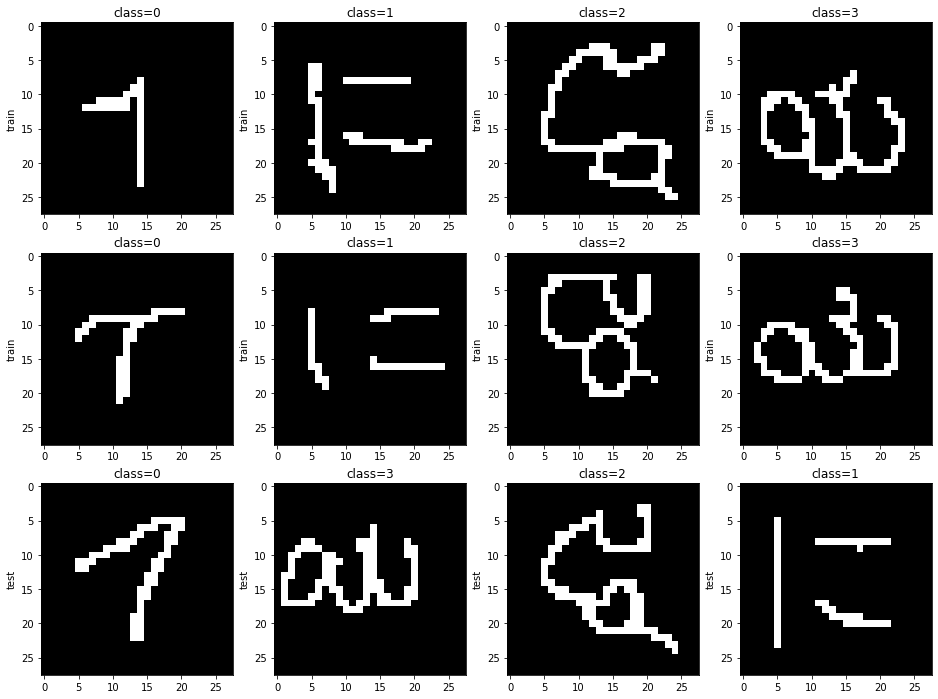

In [10]:
config = {'data_folder':'./omniglot_resized', 'img_size':(28, 28)}
num_classes=4
num_samples_per_class=3
batch_size=4
dloader = DataGenerator(num_classes=num_classes, num_samples_per_class=num_samples_per_class, config=config)
im, l = dloader.sample_batch(batch_type='train', batch_size=batch_size)

# # test the method of preparing labels to be fed to the network
# input_labels_gt = tf.identity(l[:,:-1,:,:])
# # concatenate zeros for last label
# l = tf.concat([input_labels_gt, tf.zeros((l.shape[0], 1, num_classes, num_classes), tf.float32)], axis=1).numpy()

# plot few samples for verification
plt.figure(figsize=(16,12))
for idx_s in range(num_samples_per_class):
  for idx_c in range(num_classes):
    plt.subplot(num_samples_per_class,num_classes,idx_s*num_classes+idx_c+1)
    img = np.reshape(im[0,idx_s,idx_c,:], newshape=(28,28))
    plt.imshow(img, cmap='gray')
    plt.title('class={}'.format(np.argmax(l[0,idx_s,idx_c,:])))
    if idx_s == num_samples_per_class-1:
        plt.ylabel('test')
    else:
        plt.ylabel('train')
plt.savefig('plots/dataset.png')
plt.show()

In [6]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.reshape = tf.keras.layers.Reshape((int(num_classes*samples_per_class),-1))
        self.reshape_back = tf.keras.layers.Reshape((samples_per_class,num_classes,-1))
        self.layer1 = tf.keras.layers.GRU(128, return_sequences=True)
        self.layer2 = tf.keras.layers.GRU(64, return_sequences=True)
        self.layer3 = tf.keras.layers.GRU(16, return_sequences=True)
        self.layer4 = tf.keras.layers.GRU(num_classes, return_sequences=True)
        self.ce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    @tf.function
    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        # set label for last sample in each class to zero
        input_labels_gt = tf.identity(input_labels[:,:-1,:,:])
        # concatenate zeros for last label
        input_labels_modified = tf.concat([input_labels_gt, tf.zeros((input_labels.shape[0], 1, self.num_classes, self.num_classes), tf.float32)], axis=1)
        # reshape images and labels to build a 3-dimensional vector for LSTM
        input_labels_modified = self.reshape(input_labels_modified)
        input_images = self.reshape(input_images)
        # concatenate images with labels
        concatenated_input = tf.concat([input_images, input_labels_modified], axis=-1)
        out = self.layer1(concatenated_input)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

    @tf.function
    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # extract last sample within each character and compute loss
        labels = self.reshape_back(labels)
        preds = self.reshape_back(preds)
        loss_ = self.ce(labels, preds)
        return loss_

In [4]:
# Main training function

@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss

def main(num_classes=5, num_samples=1, meta_batch_size=16, n_iterations=25000, learning_rate=0.001, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    steps = []
    losses = []
    accuracies = []
    for step in range(n_iterations):
        i, l = data_generator.sample_batch('train', meta_batch_size)

        _, ls = train_step(i, l, o, optim)

        if (step + 1) % 100 == 0:
            print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            i, l = data_generator.sample_batch('test', 100)
            pred, tls = train_step(i, l, o, optim, eval=True)
            print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()
            print("Test Accuracy", acc)

            steps.append(step)
            losses.append([ls.numpy(), tls.numpy()])
            accuracies.append(acc)

    return np.asarray(steps), np.asarray(losses), np.asarray(accuracies)


In [5]:
from collections import deque
# compute moving average
def moving_average(x, n):
    # create a deque object
    x_deque = deque(maxlen=n)
    ma_x = []
    for x_ in x:
        x_deque.append(x_)
        ma_x.append(np.mean(x_deque))
    return np.array(ma_x)

*****Iter 100*****
Train Loss: 0.4592961 Test Loss: 0.45593444
Test Accuracy 0.505
*****Iter 200*****
Train Loss: 0.44740778 Test Loss: 0.44770402
Test Accuracy 0.565
*****Iter 300*****
Train Loss: 0.44485337 Test Loss: 0.44651163
Test Accuracy 0.5
*****Iter 400*****
Train Loss: 0.43439773 Test Loss: 0.41621435
Test Accuracy 0.535
*****Iter 500*****
Train Loss: 0.46392477 Test Loss: 0.32834426
Test Accuracy 0.755
*****Iter 600*****
Train Loss: 0.39146867 Test Loss: 0.354199
Test Accuracy 0.8
*****Iter 700*****
Train Loss: 0.50251544 Test Loss: 0.42256346
Test Accuracy 0.49
*****Iter 800*****
Train Loss: 0.35388505 Test Loss: 0.4356226
Test Accuracy 0.45
*****Iter 900*****
Train Loss: 0.4134344 Test Loss: 0.47889078
Test Accuracy 0.505
*****Iter 1000*****
Train Loss: 0.44680068 Test Loss: 0.4238092
Test Accuracy 0.645
*****Iter 1100*****
Train Loss: 0.35853183 Test Loss: 0.4267513
Test Accuracy 0.685
*****Iter 1200*****
Train Loss: 0.42324108 Test Loss: 0.41230488
Test Accuracy 0.48
***

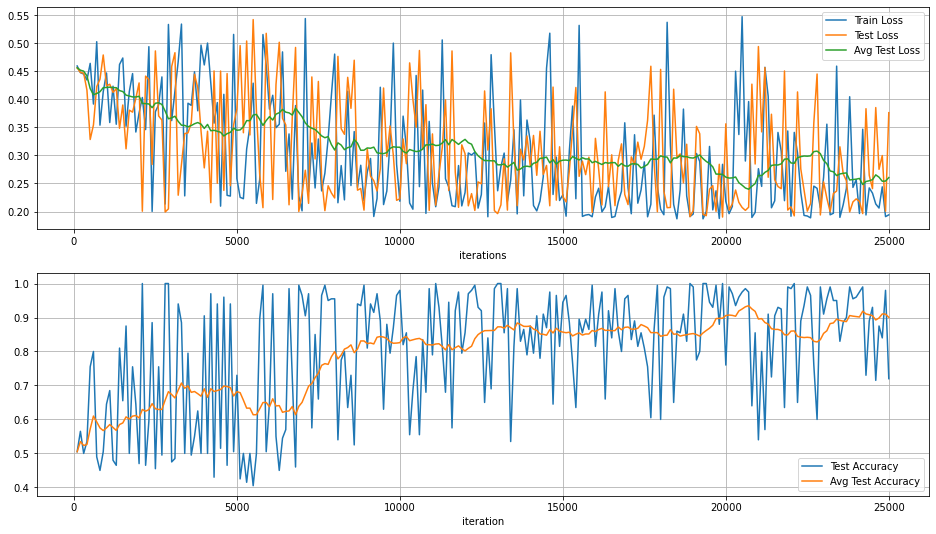

In [6]:
# K = 1, N = 2
num_samples_per_class=1
num_classes=2
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot.png'.format(num_classes, num_samples_per_class))
# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

*****Iter 100*****
Train Loss: 0.7971186 Test Loss: 0.7860246
Test Accuracy 0.42
*****Iter 200*****
Train Loss: 0.7221532 Test Loss: 0.7282782
Test Accuracy 0.32666665
*****Iter 300*****
Train Loss: 0.72134185 Test Loss: 0.7210484
Test Accuracy 0.33
*****Iter 400*****
Train Loss: 0.72277266 Test Loss: 0.7220598
Test Accuracy 0.36
*****Iter 500*****
Train Loss: 0.7243226 Test Loss: 0.72183084
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.72297555 Test Loss: 0.72169346
Test Accuracy 0.37
*****Iter 700*****
Train Loss: 0.72110564 Test Loss: 0.72100604
Test Accuracy 0.30333334
*****Iter 800*****
Train Loss: 0.7218469 Test Loss: 0.72079164
Test Accuracy 0.25666666
*****Iter 900*****
Train Loss: 0.7213285 Test Loss: 0.72084516
Test Accuracy 0.25
*****Iter 1000*****
Train Loss: 0.7208431 Test Loss: 0.72072756
Test Accuracy 0.34
*****Iter 1100*****
Train Loss: 0.7213684 Test Loss: 0.7217118
Test Accuracy 0.42333335
*****Iter 1200*****
Train Loss: 0.72080183 Test Loss: 0.72241825
Te

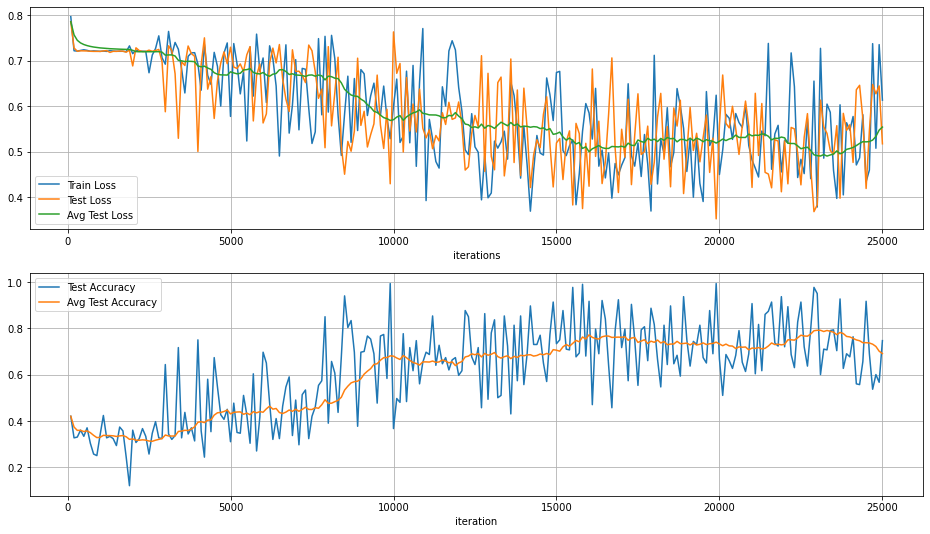

In [7]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot.png'.format(num_classes, num_samples_per_class))
# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

*****Iter 100*****
Train Loss: 1.0127778 Test Loss: 1.0251712
Test Accuracy 0.235
*****Iter 200*****
Train Loss: 0.9526442 Test Loss: 0.95466894
Test Accuracy 0.24
*****Iter 300*****
Train Loss: 0.9449707 Test Loss: 0.95011556
Test Accuracy 0.2875
*****Iter 400*****
Train Loss: 0.93809336 Test Loss: 0.9377972
Test Accuracy 0.42
*****Iter 500*****
Train Loss: 0.93658817 Test Loss: 0.93166757
Test Accuracy 0.2975
*****Iter 600*****
Train Loss: 0.9558177 Test Loss: 0.9360651
Test Accuracy 0.1925
*****Iter 700*****
Train Loss: 0.9367627 Test Loss: 0.9348881
Test Accuracy 0.2325
*****Iter 800*****
Train Loss: 0.9350775 Test Loss: 0.93573576
Test Accuracy 0.25
*****Iter 900*****
Train Loss: 0.93264604 Test Loss: 0.93334657
Test Accuracy 0.23
*****Iter 1000*****
Train Loss: 0.93358386 Test Loss: 0.9346572
Test Accuracy 0.1875
*****Iter 1100*****
Train Loss: 0.9350534 Test Loss: 0.93478316
Test Accuracy 0.2125
*****Iter 1200*****
Train Loss: 0.9343017 Test Loss: 0.9343129
Test Accuracy 0.3425


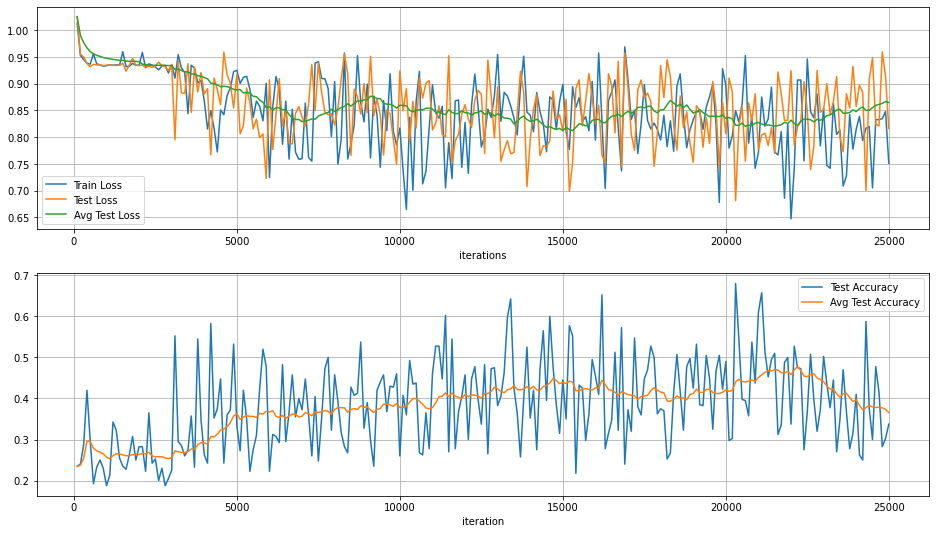

In [8]:
# K = 1, N = 4
num_samples_per_class=1
num_classes=4
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot.png'.format(num_classes, num_samples_per_class))
# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

*****Iter 100*****
Train Loss: 0.9007611 Test Loss: 0.914311
Test Accuracy 0.24
*****Iter 200*****
Train Loss: 0.8503359 Test Loss: 0.81721026
Test Accuracy 0.2225
*****Iter 300*****
Train Loss: 0.81096965 Test Loss: 0.8059836
Test Accuracy 0.2425
*****Iter 400*****
Train Loss: 0.7976404 Test Loss: 0.8117751
Test Accuracy 0.25
*****Iter 500*****
Train Loss: 0.8097616 Test Loss: 0.799385
Test Accuracy 0.2375
*****Iter 600*****
Train Loss: 0.78520447 Test Loss: 0.78467554
Test Accuracy 0.2725
*****Iter 700*****
Train Loss: 0.7676938 Test Loss: 0.7664112
Test Accuracy 0.25
*****Iter 800*****
Train Loss: 0.7641566 Test Loss: 0.76800424
Test Accuracy 0.2775
*****Iter 900*****
Train Loss: 0.76188064 Test Loss: 0.7757019
Test Accuracy 0.1775
*****Iter 1000*****
Train Loss: 0.76490736 Test Loss: 0.762239
Test Accuracy 0.2575
*****Iter 1100*****
Train Loss: 0.75940967 Test Loss: 0.7674247
Test Accuracy 0.185
*****Iter 1200*****
Train Loss: 0.75605774 Test Loss: 0.7378273
Test Accuracy 0.445
***

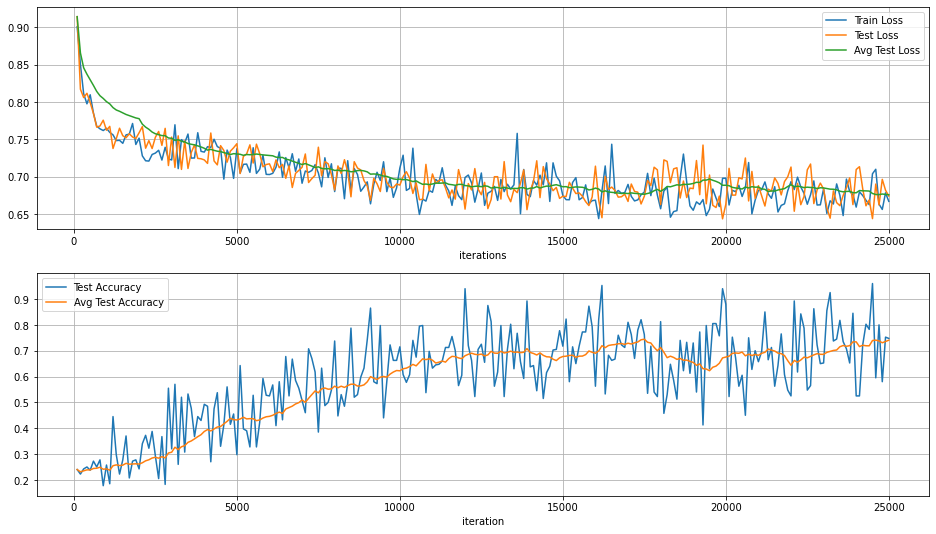

In [9]:
# K = 5, N = 4
num_samples_per_class=5
num_classes=4
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot.png'.format(num_classes, num_samples_per_class))
# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

# Plot all losses in one graph

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

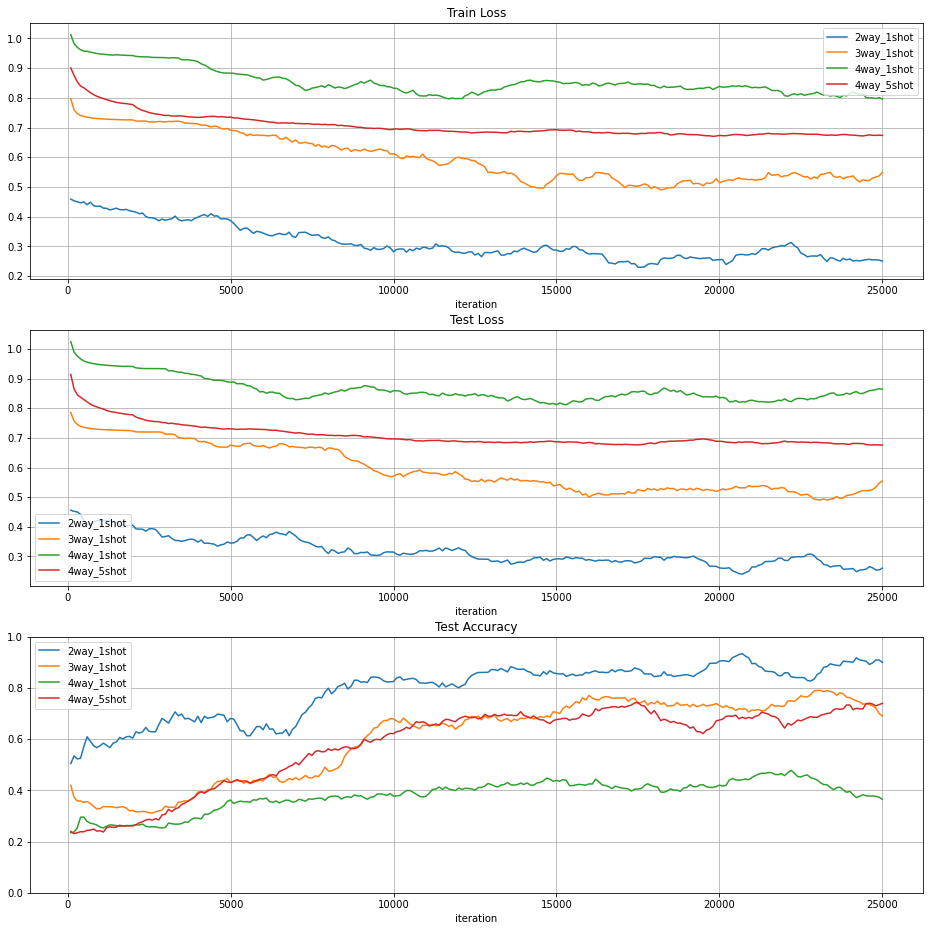

In [17]:
csv_log_files = ['logs/log_2way_1shot.csv',
                 'logs/log_3way_1shot.csv',
                 'logs/log_4way_1shot.csv',
                 'logs/log_4way_5shot.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_few_shot_plots.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.ylim(0.0, 1.0)
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

# Let's try this with different set of hyperparameters now

### Lower learning rate

Achieved test accuracy: 56.93%


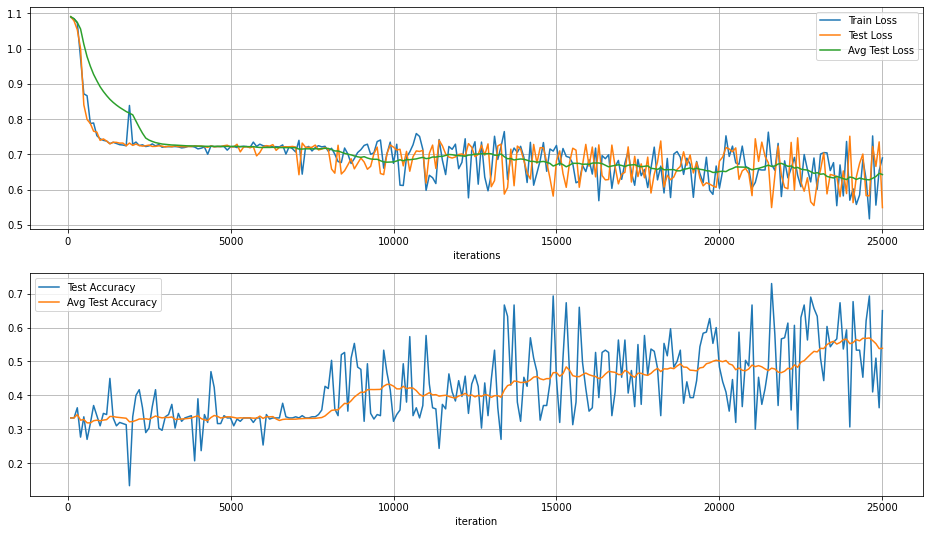

In [7]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
lr = 0.0001
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lr{}.csv'.format(num_classes, num_samples_per_class, lr))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lr{}.png'.format(num_classes, num_samples_per_class, lr))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, learning_rate=lr, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Higher Learning Rate

*****Iter 100*****
Train Loss: 0.8640215 Test Loss: 0.8614686
Test Accuracy 0.34
*****Iter 200*****
Train Loss: 0.86262196 Test Loss: 0.86250836
Test Accuracy 0.33333334
*****Iter 300*****
Train Loss: 0.8626434 Test Loss: 0.8625709
Test Accuracy 0.33333334
*****Iter 400*****
Train Loss: 0.86257887 Test Loss: 0.8625714
Test Accuracy 0.33333334
*****Iter 500*****
Train Loss: 0.8625207 Test Loss: 0.8625572
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.8613748 Test Loss: 0.86269534
Test Accuracy 0.33333334
*****Iter 700*****
Train Loss: 0.79905295 Test Loss: 0.79907244
Test Accuracy 0.33333334
*****Iter 800*****
Train Loss: 0.79888844 Test Loss: 0.7989344
Test Accuracy 0.33333334
*****Iter 900*****
Train Loss: 0.7986366 Test Loss: 0.7989705
Test Accuracy 0.33333334
*****Iter 1000*****
Train Loss: 0.79901284 Test Loss: 0.79895765
Test Accuracy 0.33333334
*****Iter 1100*****
Train Loss: 0.79907924 Test Loss: 0.79895765
Test Accuracy 0.33333334
*****Iter 1200*****
Train Loss: 0.79

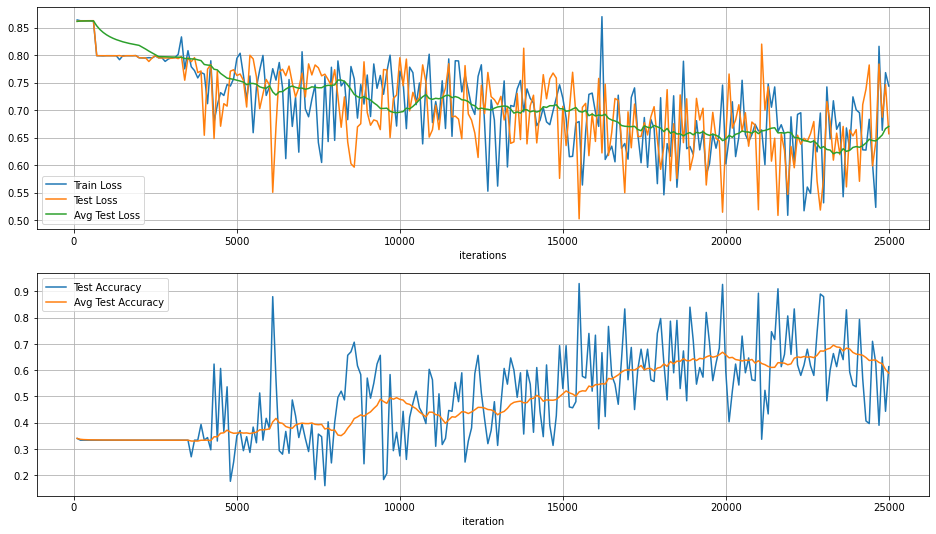

In [9]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
lr = 0.005
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lr{}.csv'.format(num_classes, num_samples_per_class, lr))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lr{}.png'.format(num_classes, num_samples_per_class, lr))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, learning_rate=lr, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

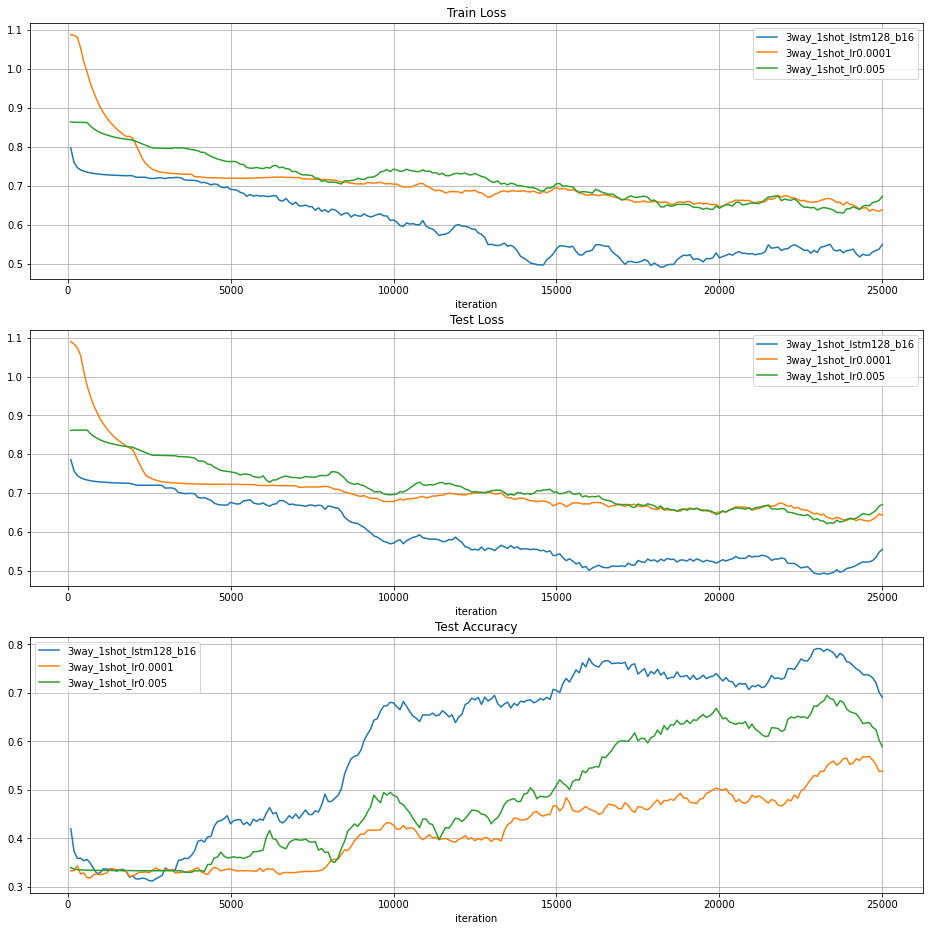

In [15]:
csv_log_files = ['logs/log_3way_1shot_lstm128_b16.csv',
                 'logs/log_3way_1shot_lr0.0001.csv',
                 'logs/log_3way_1shot_lr0.005.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_3way_1shot_lr.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### LSTM with smaller number of hidden cells

*****Iter 100*****
Train Loss: 0.9333628 Test Loss: 0.91141874
Test Accuracy 0.35333332
*****Iter 200*****
Train Loss: 0.7357399 Test Loss: 0.7398266
Test Accuracy 0.40333334
*****Iter 300*****
Train Loss: 0.7248244 Test Loss: 0.7233194
Test Accuracy 0.34333333
*****Iter 400*****
Train Loss: 0.72373885 Test Loss: 0.72678065
Test Accuracy 0.29
*****Iter 500*****
Train Loss: 0.7288589 Test Loss: 0.7268715
Test Accuracy 0.30333334
*****Iter 600*****
Train Loss: 0.73026294 Test Loss: 0.72763807
Test Accuracy 0.31333333
*****Iter 700*****
Train Loss: 0.7199281 Test Loss: 0.7224752
Test Accuracy 0.38333333
*****Iter 800*****
Train Loss: 0.7318966 Test Loss: 0.72104317
Test Accuracy 0.47333333
*****Iter 900*****
Train Loss: 0.7248456 Test Loss: 0.72231627
Test Accuracy 0.3
*****Iter 1000*****
Train Loss: 0.72131044 Test Loss: 0.7204055
Test Accuracy 0.50333333
*****Iter 1100*****
Train Loss: 0.72712946 Test Loss: 0.73446566
Test Accuracy 0.23333333
*****Iter 1200*****
Train Loss: 0.7267658 Te

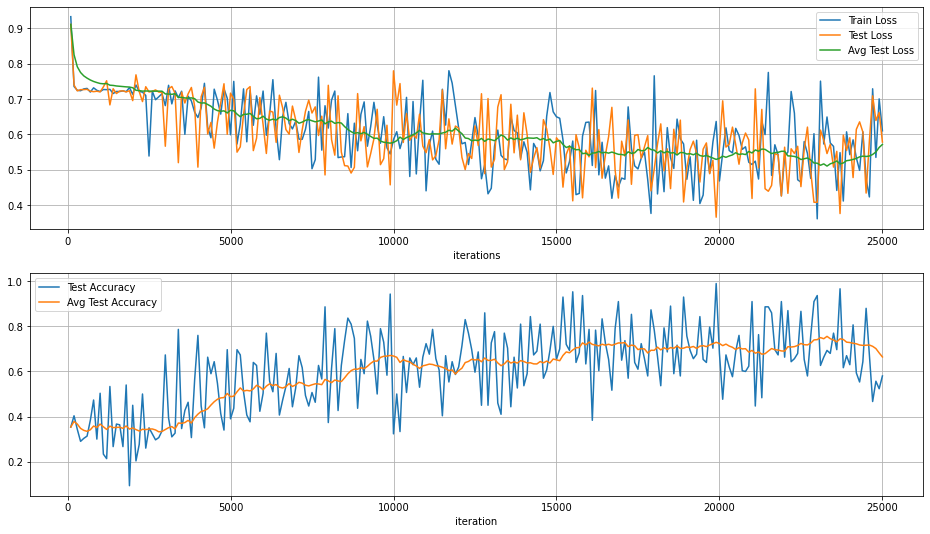

In [34]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lstm64.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lstm64.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

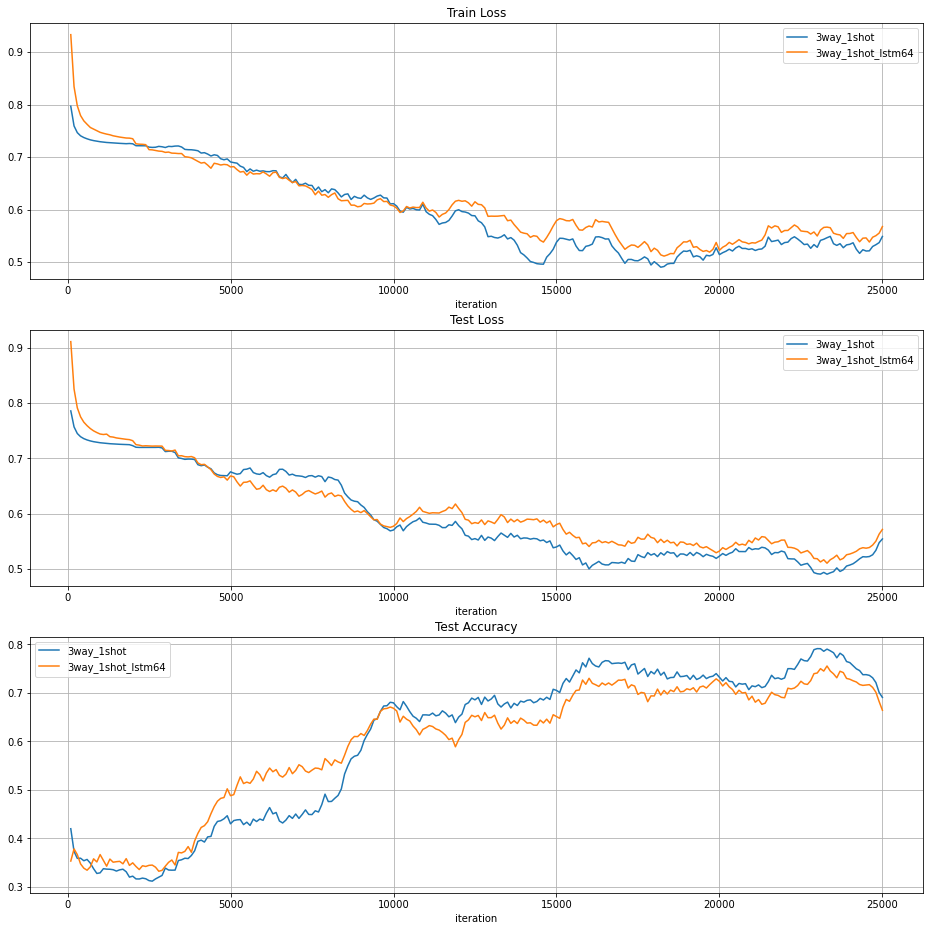

In [35]:
csv_log_files = ['logs/log_3way_1shot.csv',
                 'logs/log_3way_1shot_lstm64.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_lstm64.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### Didn't improve results, let's go with higher number of LSTM hidden units

*****Iter 100*****
Train Loss: 0.7588002 Test Loss: 0.757126
Test Accuracy 0.38
*****Iter 200*****
Train Loss: 0.7539055 Test Loss: 0.75299793
Test Accuracy 0.31
*****Iter 300*****
Train Loss: 0.7485756 Test Loss: 0.7484145
Test Accuracy 0.33333334
*****Iter 400*****
Train Loss: 0.7484796 Test Loss: 0.7485893
Test Accuracy 0.33333334
*****Iter 500*****
Train Loss: 0.74836206 Test Loss: 0.7483988
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.74823195 Test Loss: 0.74885935
Test Accuracy 0.33333334
*****Iter 700*****
Train Loss: 0.7482565 Test Loss: 0.74827486
Test Accuracy 0.33333334
*****Iter 800*****
Train Loss: 0.7484233 Test Loss: 0.748216
Test Accuracy 0.33333334
*****Iter 900*****
Train Loss: 0.74824935 Test Loss: 0.7482135
Test Accuracy 0.33333334
*****Iter 1000*****
Train Loss: 0.74827546 Test Loss: 0.7490677
Test Accuracy 0.33333334
*****Iter 1100*****
Train Loss: 0.74826384 Test Loss: 0.7482515
Test Accuracy 0.33333334
*****Iter 1200*****
Train Loss: 0.7483065 Test 

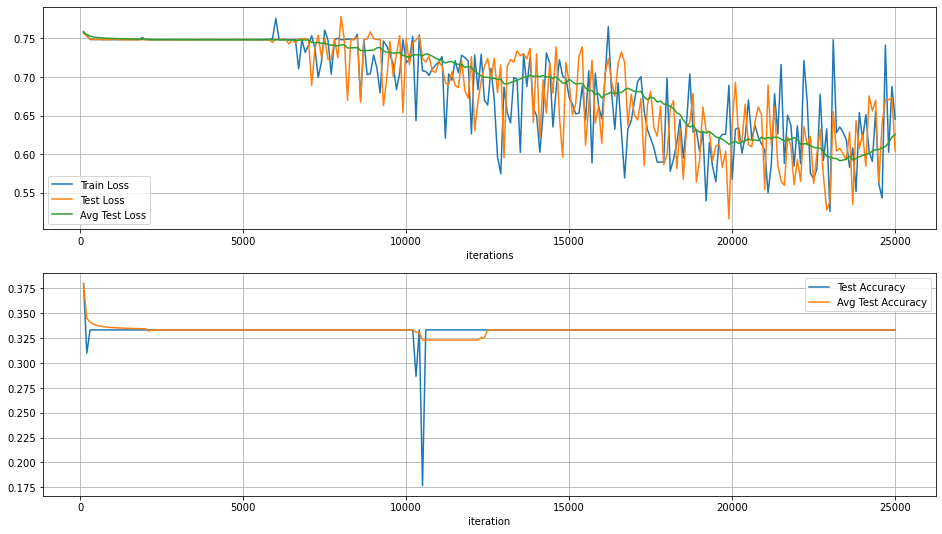

In [37]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lstm256.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lstm256.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

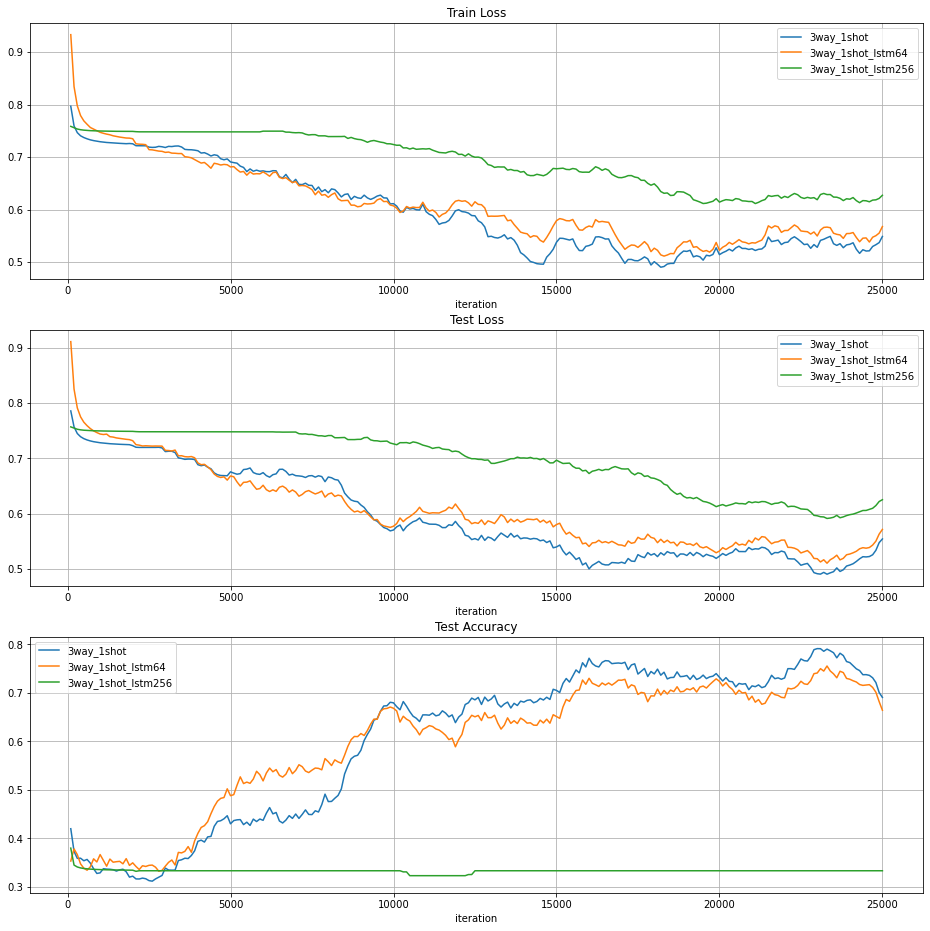

In [40]:
csv_log_files = ['logs/log_3way_1shot.csv',
                 'logs/log_3way_1shot_lstm64.csv',
                 'logs/log_3way_1shot_lstm256.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_lstm256.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### Train a network with batch size=16

*****Iter 100*****
Train Loss: 0.7971186 Test Loss: 0.7860246
Test Accuracy 0.42
*****Iter 200*****
Train Loss: 0.7221532 Test Loss: 0.7282782
Test Accuracy 0.32666665
*****Iter 300*****
Train Loss: 0.72134185 Test Loss: 0.7210484
Test Accuracy 0.33
*****Iter 400*****
Train Loss: 0.72277266 Test Loss: 0.7220598
Test Accuracy 0.36
*****Iter 500*****
Train Loss: 0.7243226 Test Loss: 0.72183084
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.72297555 Test Loss: 0.72169346
Test Accuracy 0.37
*****Iter 700*****
Train Loss: 0.72110564 Test Loss: 0.72100604
Test Accuracy 0.30333334
*****Iter 800*****
Train Loss: 0.7218469 Test Loss: 0.72079164
Test Accuracy 0.25666666
*****Iter 900*****
Train Loss: 0.7213285 Test Loss: 0.72084516
Test Accuracy 0.25
*****Iter 1000*****
Train Loss: 0.7208431 Test Loss: 0.72072756
Test Accuracy 0.34
*****Iter 1100*****
Train Loss: 0.7213684 Test Loss: 0.7217118
Test Accuracy 0.42333335
*****Iter 1200*****
Train Loss: 0.72080183 Test Loss: 0.72241825
Te

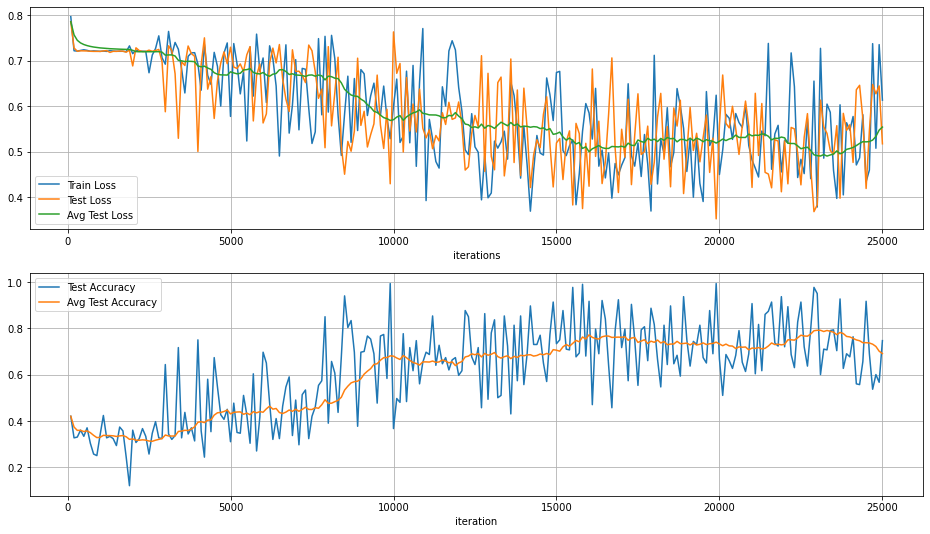

In [10]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lstm128_b16.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lstm128_b16.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Let's replace LSTM with a GRU

*****Iter 100*****
Train Loss: 0.69786793 Test Loss: 0.6726298
Test Accuracy 0.39333335
*****Iter 200*****
Train Loss: 0.6689877 Test Loss: 0.6731979
Test Accuracy 0.25333333
*****Iter 300*****
Train Loss: 0.63842845 Test Loss: 0.6603288
Test Accuracy 0.35333332
*****Iter 400*****
Train Loss: 0.6600482 Test Loss: 0.6788086
Test Accuracy 0.28333333
*****Iter 500*****
Train Loss: 0.6703574 Test Loss: 0.6695516
Test Accuracy 0.3
*****Iter 600*****
Train Loss: 0.6700132 Test Loss: 0.6687108
Test Accuracy 0.43
*****Iter 700*****
Train Loss: 0.6695973 Test Loss: 0.66946703
Test Accuracy 0.34
*****Iter 800*****
Train Loss: 0.66938305 Test Loss: 0.66922575
Test Accuracy 0.34
*****Iter 900*****
Train Loss: 0.66943425 Test Loss: 0.6693999
Test Accuracy 0.12666667
*****Iter 1000*****
Train Loss: 0.6693177 Test Loss: 0.6674543
Test Accuracy 0.46
*****Iter 1100*****
Train Loss: 0.6654919 Test Loss: 0.68414056
Test Accuracy 0.27666667
*****Iter 1200*****
Train Loss: 0.66927314 Test Loss: 0.6692787
T

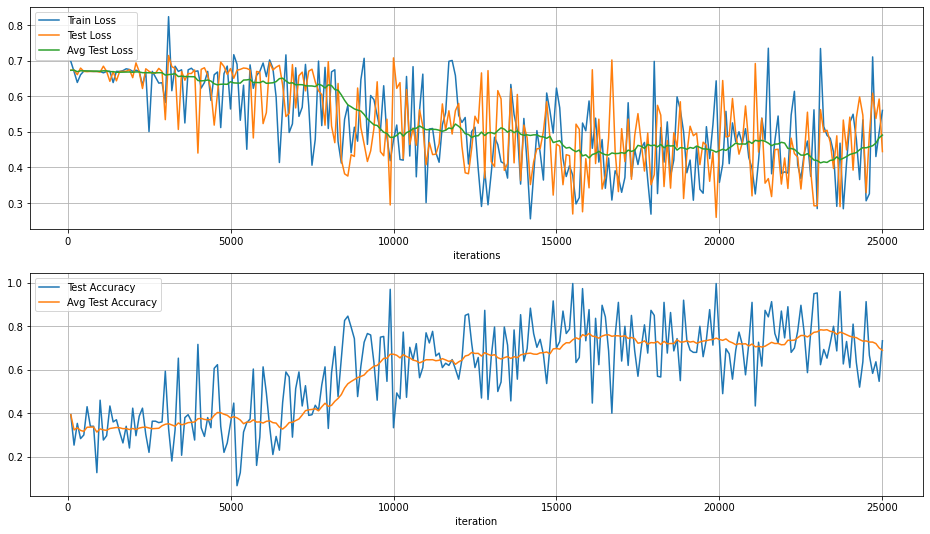

In [7]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                'train_loss', \
                'test_loss',  \
                'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

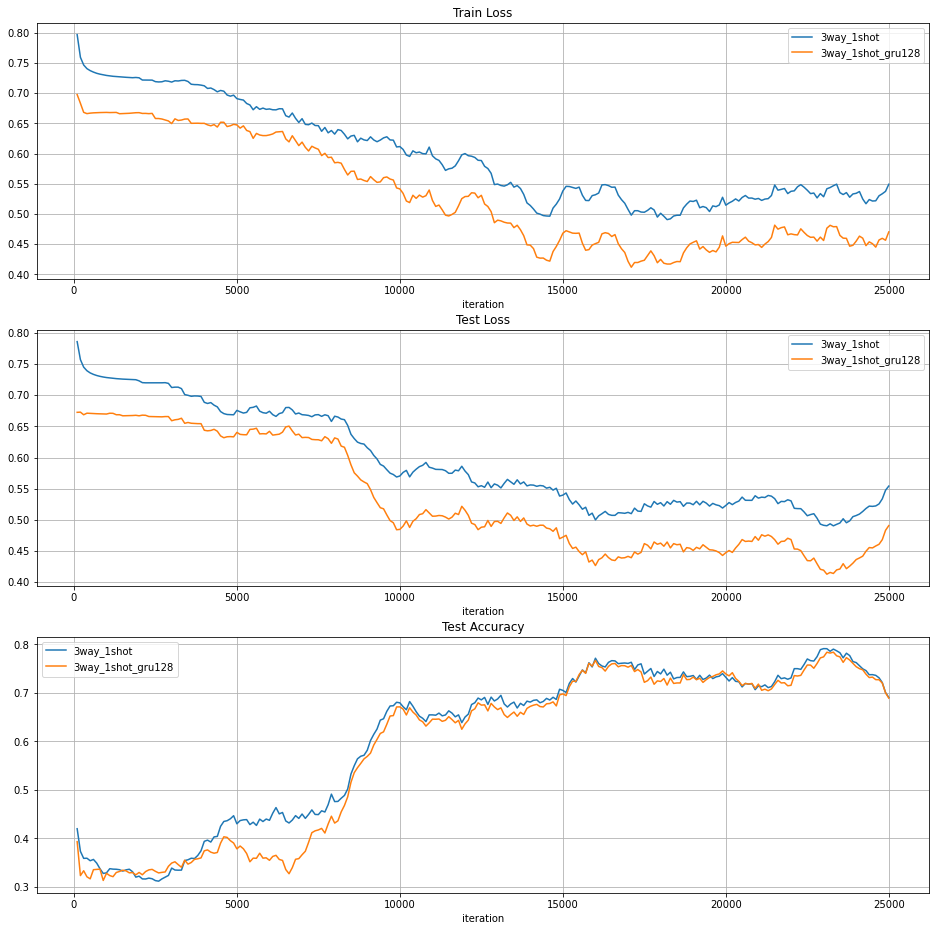

In [20]:
csv_log_files = ['logs/log_3way_1shot.csv',
                 'logs/log_3way_1shot_gru128.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_lstm_gru.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### GRU seems to work better, try with more units

*****Iter 100*****
Train Loss: 0.67721796 Test Loss: 0.67486954
Test Accuracy 0.40333334
*****Iter 200*****
Train Loss: 0.6681237 Test Loss: 0.67149657
Test Accuracy 0.16
*****Iter 300*****
Train Loss: 0.66926 Test Loss: 0.6692538
Test Accuracy 0.41666666
*****Iter 400*****
Train Loss: 0.6695555 Test Loss: 0.67024
Test Accuracy 0.32333332
*****Iter 500*****
Train Loss: 0.67760164 Test Loss: 0.6701498
Test Accuracy 0.32
*****Iter 600*****
Train Loss: 0.6703208 Test Loss: 0.668527
Test Accuracy 0.34
*****Iter 700*****
Train Loss: 0.67089367 Test Loss: 0.66983664
Test Accuracy 0.3
*****Iter 800*****
Train Loss: 0.6697057 Test Loss: 0.6695038
Test Accuracy 0.33333334
*****Iter 900*****
Train Loss: 0.66937023 Test Loss: 0.6694555
Test Accuracy 0.32
*****Iter 1000*****
Train Loss: 0.6692508 Test Loss: 0.66919816
Test Accuracy 0.62666667
*****Iter 1100*****
Train Loss: 0.6627143 Test Loss: 0.67471415
Test Accuracy 0.30333334
*****Iter 1200*****
Train Loss: 0.66903716 Test Loss: 0.6706793
Test

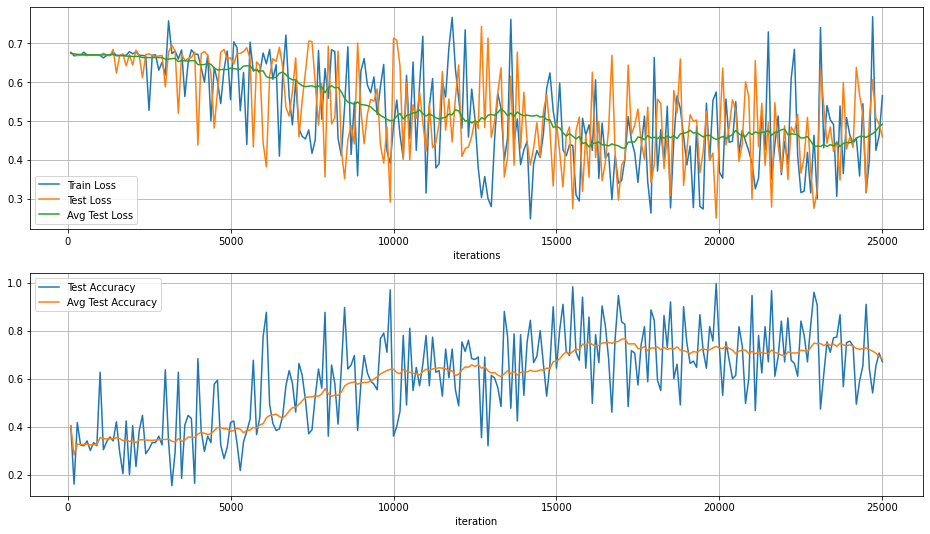

In [14]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

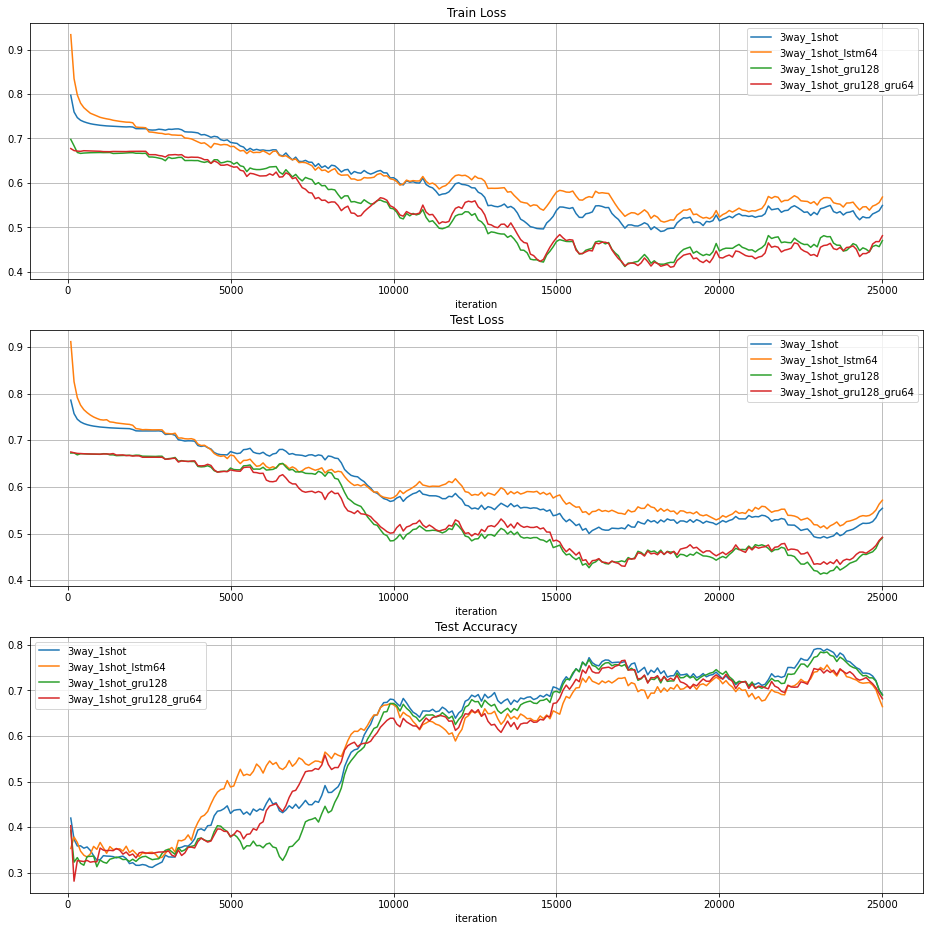

In [15]:
csv_log_files = ['logs/log_3way_1shot.csv',
                 'logs/log_3way_1shot_lstm64.csv',
                 'logs/log_3way_1shot_gru128.csv',
                 'logs/log_3way_1shot_gru128_gru64.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_gru128_gru64.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### That's even better, let's try adding one more layer

*****Iter 100*****
Train Loss: 0.7122188 Test Loss: 0.7072684
Test Accuracy 0.35
*****Iter 200*****
Train Loss: 0.6774567 Test Loss: 0.67560285
Test Accuracy 0.38
*****Iter 300*****
Train Loss: 0.6708588 Test Loss: 0.6717961
Test Accuracy 0.33
*****Iter 400*****
Train Loss: 0.6716767 Test Loss: 0.6708296
Test Accuracy 0.33
*****Iter 500*****
Train Loss: 0.6706374 Test Loss: 0.6710807
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.67108744 Test Loss: 0.67090225
Test Accuracy 0.30666667
*****Iter 700*****
Train Loss: 0.67099524 Test Loss: 0.67026854
Test Accuracy 0.33333334
*****Iter 800*****
Train Loss: 0.66935396 Test Loss: 0.6699133
Test Accuracy 0.34666666
*****Iter 900*****
Train Loss: 0.66879684 Test Loss: 0.66978085
Test Accuracy 0.30333334
*****Iter 1000*****
Train Loss: 0.6695263 Test Loss: 0.6697643
Test Accuracy 0.36333334
*****Iter 1100*****
Train Loss: 0.670063 Test Loss: 0.66975397
Test Accuracy 0.33333334
*****Iter 1200*****
Train Loss: 0.66999197 Test Loss: 0.6

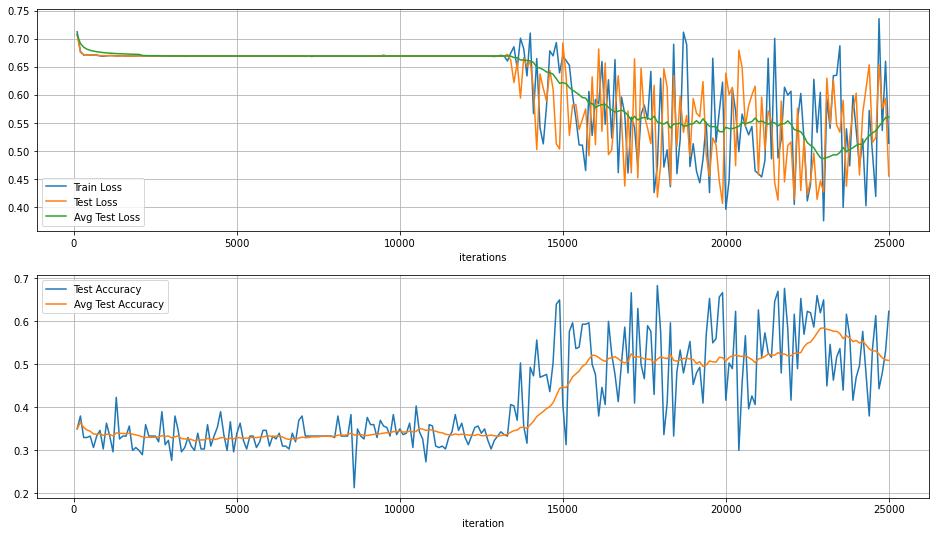

In [19]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64_gru32.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64_gru32.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

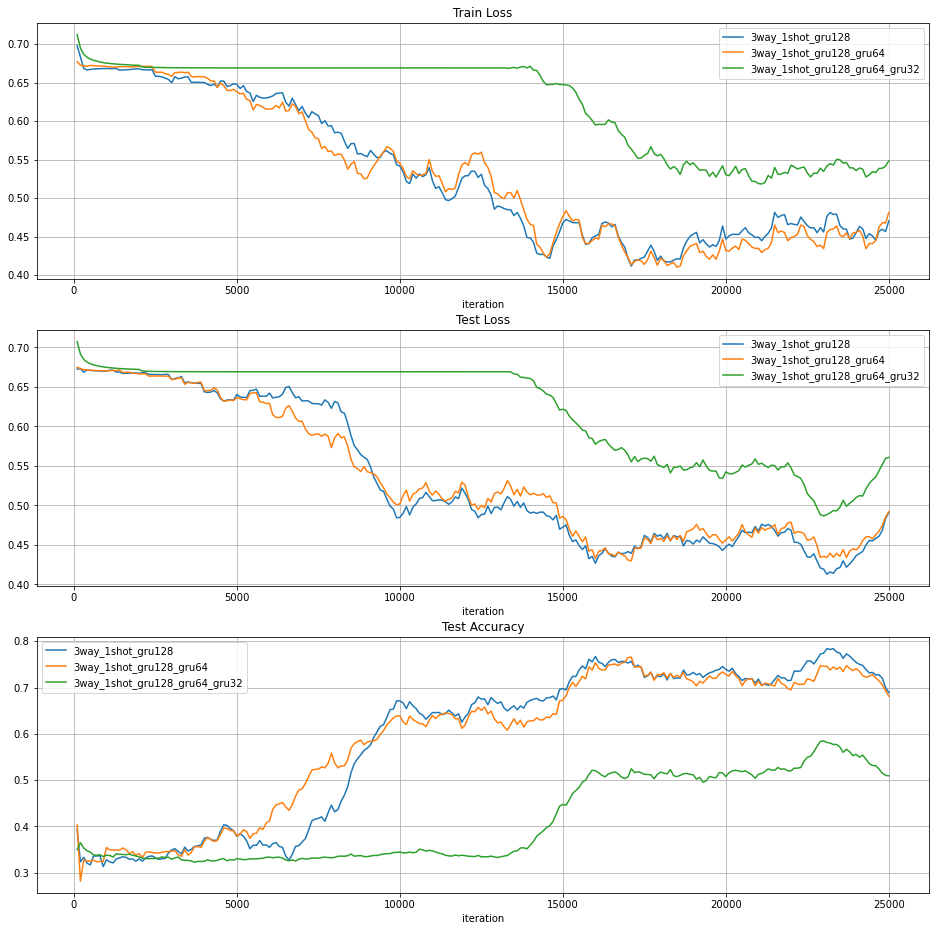

In [20]:
csv_log_files = ['logs/log_3way_1shot_gru128.csv',
                 'logs/log_3way_1shot_gru128_gru64.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru32.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_gru128_gru64_gru32.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### Use smaller number of cells in the last layer (16)

*****Iter 100*****
Train Loss: 0.7646597 Test Loss: 0.73719823
Test Accuracy 0.47666666
*****Iter 200*****
Train Loss: 0.6956756 Test Loss: 0.6913523
Test Accuracy 0.31666666
*****Iter 300*****
Train Loss: 0.67772406 Test Loss: 0.6764787
Test Accuracy 0.38333333
*****Iter 400*****
Train Loss: 0.6732605 Test Loss: 0.68582726
Test Accuracy 0.22333333
*****Iter 500*****
Train Loss: 0.6857531 Test Loss: 0.6782343
Test Accuracy 0.32666665
*****Iter 600*****
Train Loss: 0.7034373 Test Loss: 0.6026212
Test Accuracy 0.60333335
*****Iter 700*****
Train Loss: 0.6564396 Test Loss: 0.6760906
Test Accuracy 0.33333334
*****Iter 800*****
Train Loss: 0.6014048 Test Loss: 0.6655367
Test Accuracy 0.37
*****Iter 900*****
Train Loss: 0.68978286 Test Loss: 0.66401595
Test Accuracy 0.42
*****Iter 1000*****
Train Loss: 0.6766042 Test Loss: 0.6584932
Test Accuracy 0.47333333
*****Iter 1100*****
Train Loss: 0.5541131 Test Loss: 0.6707199
Test Accuracy 0.38666666
*****Iter 1200*****
Train Loss: 0.71777266 Test 

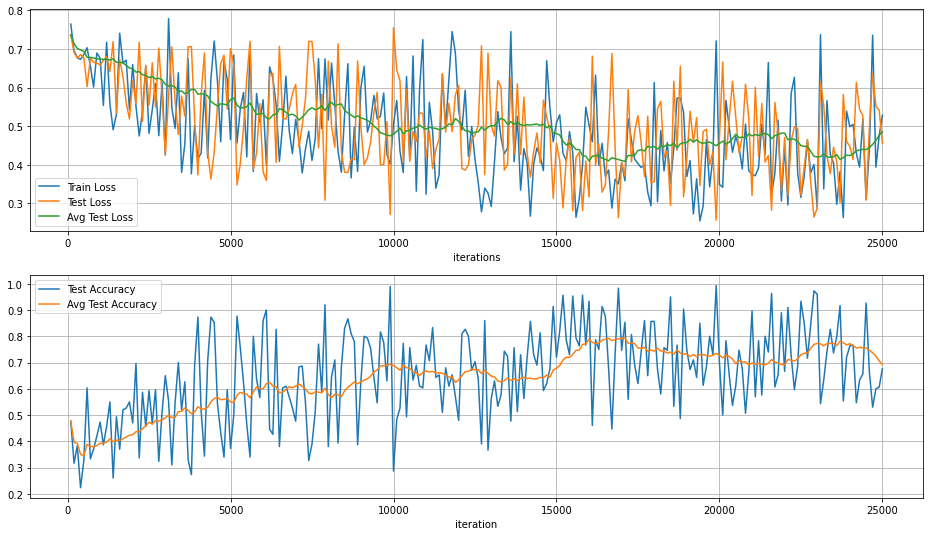

In [22]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64_gru16.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64_gru16.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

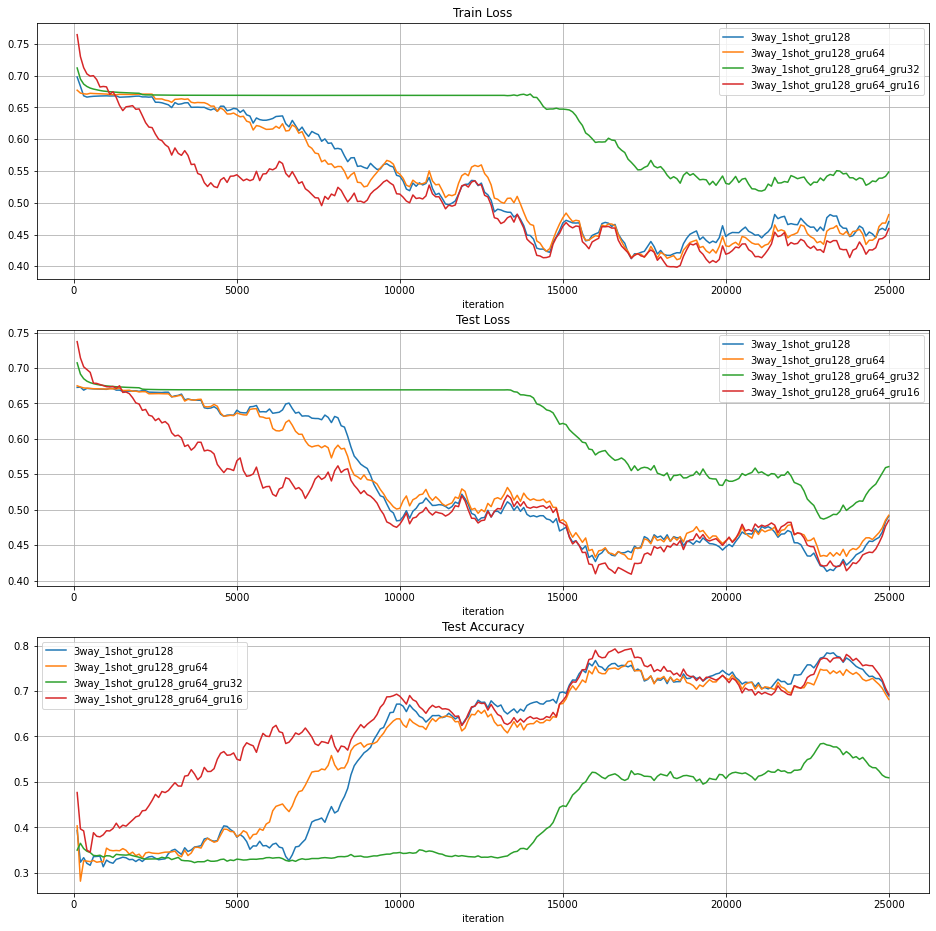

In [22]:
csv_log_files = ['logs/log_3way_1shot_gru128.csv',
                 'logs/log_3way_1shot_gru128_gru64.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru32.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru16.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_gru128_64_32_16.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### We have a winner. The network with 3 GRU layers (128, 64, 16) seems to work the best

### Higher Batch Size?

*****Iter 100*****
Train Loss: 0.6951542 Test Loss: 0.7389846
Test Accuracy 0.34666666
*****Iter 200*****
Train Loss: 0.68659073 Test Loss: 0.6883335
Test Accuracy 0.33333334
*****Iter 300*****
Train Loss: 0.70083 Test Loss: 0.65826386
Test Accuracy 0.46333334
*****Iter 400*****
Train Loss: 0.69700575 Test Loss: 0.6732604
Test Accuracy 0.37333333
*****Iter 500*****
Train Loss: 0.67525774 Test Loss: 0.67489886
Test Accuracy 0.33333334
*****Iter 600*****
Train Loss: 0.6738779 Test Loss: 0.67312974
Test Accuracy 0.33
*****Iter 700*****
Train Loss: 0.673407 Test Loss: 0.67198867
Test Accuracy 0.34
*****Iter 800*****
Train Loss: 0.6727055 Test Loss: 0.6709939
Test Accuracy 0.37333333
*****Iter 900*****
Train Loss: 0.6728318 Test Loss: 0.67250395
Test Accuracy 0.34333333
*****Iter 1000*****
Train Loss: 0.67190033 Test Loss: 0.673454
Test Accuracy 0.3
*****Iter 1100*****
Train Loss: 0.6850539 Test Loss: 0.6867872
Test Accuracy 0.20666666
*****Iter 1200*****
Train Loss: 0.6708153 Test Loss: 0.

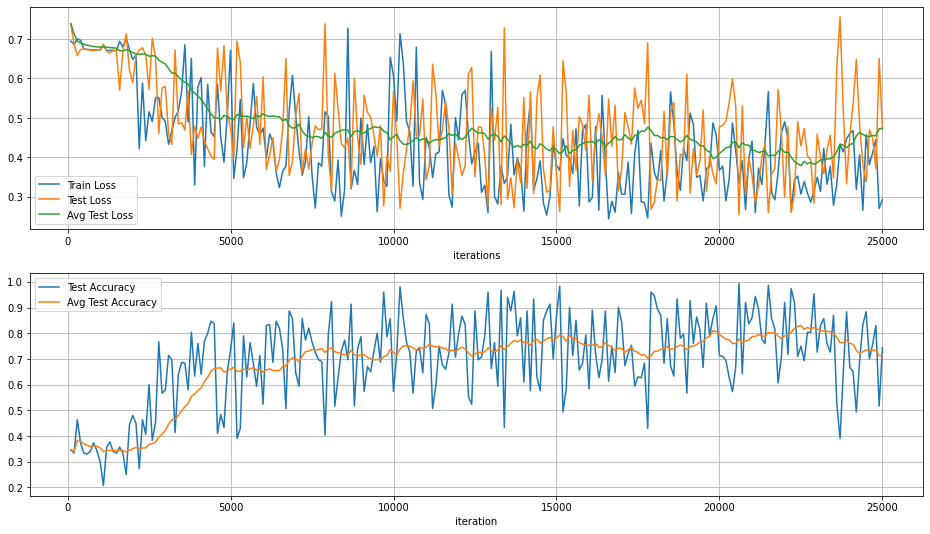

In [60]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=64
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64_gru16_b64.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64_gru16_b64.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

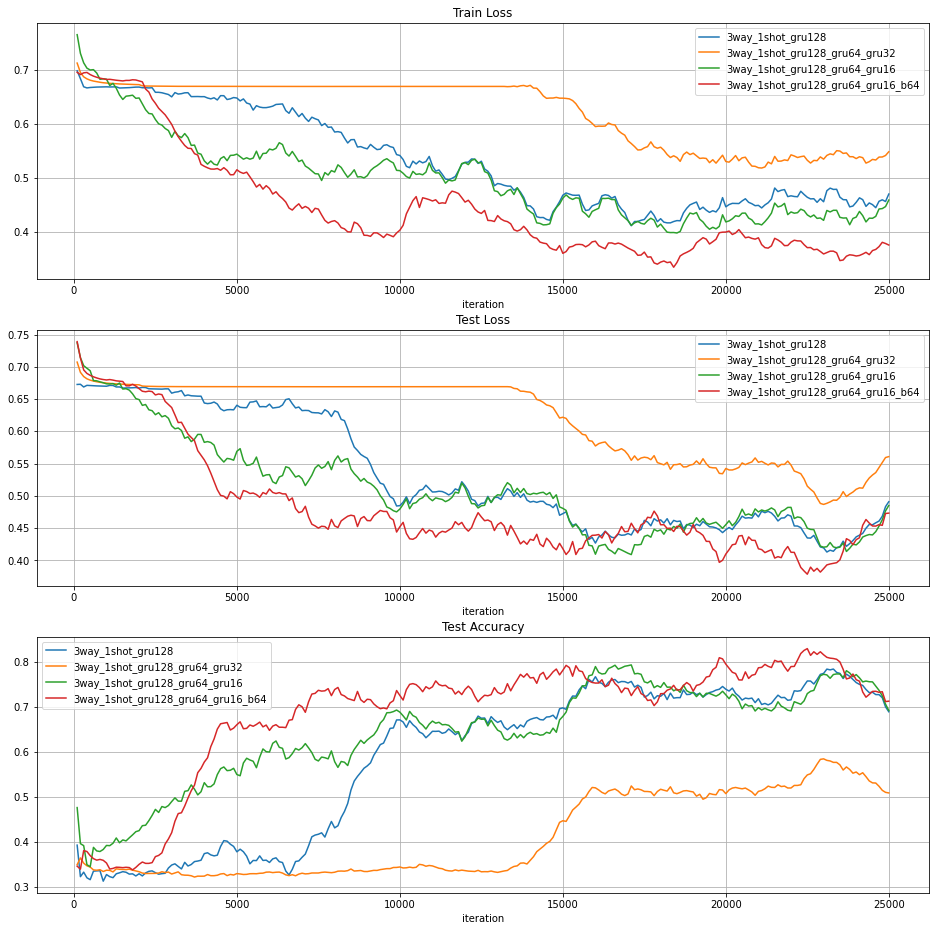

In [61]:
csv_log_files = ['logs/log_3way_1shot_gru128.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru32.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru16.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru16_b64.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_gru128_64_32_16_b64.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### Try batch size of 128

*****Iter 100*****
Train Loss: 0.7409792 Test Loss: 0.7362624
Test Accuracy 0.33
*****Iter 200*****
Train Loss: 0.70542884 Test Loss: 0.68829143
Test Accuracy 0.33666667
*****Iter 300*****
Train Loss: 0.6783685 Test Loss: 0.6801837
Test Accuracy 0.24666667
*****Iter 400*****
Train Loss: 0.6745047 Test Loss: 0.6755217
Test Accuracy 0.35333332
*****Iter 500*****
Train Loss: 0.67479295 Test Loss: 0.67258704
Test Accuracy 0.35666665
*****Iter 600*****
Train Loss: 0.67326325 Test Loss: 0.67413145
Test Accuracy 0.33
*****Iter 700*****
Train Loss: 0.66993827 Test Loss: 0.6700521
Test Accuracy 0.41333333
*****Iter 800*****
Train Loss: 0.670765 Test Loss: 0.67124295
Test Accuracy 0.33333334
*****Iter 900*****
Train Loss: 0.66920084 Test Loss: 0.66980916
Test Accuracy 0.36666667
*****Iter 1000*****
Train Loss: 0.67079633 Test Loss: 0.67007786
Test Accuracy 0.44
*****Iter 1100*****
Train Loss: 0.6702819 Test Loss: 0.6708819
Test Accuracy 0.33333334
*****Iter 1200*****
Train Loss: 0.6680062 Test L

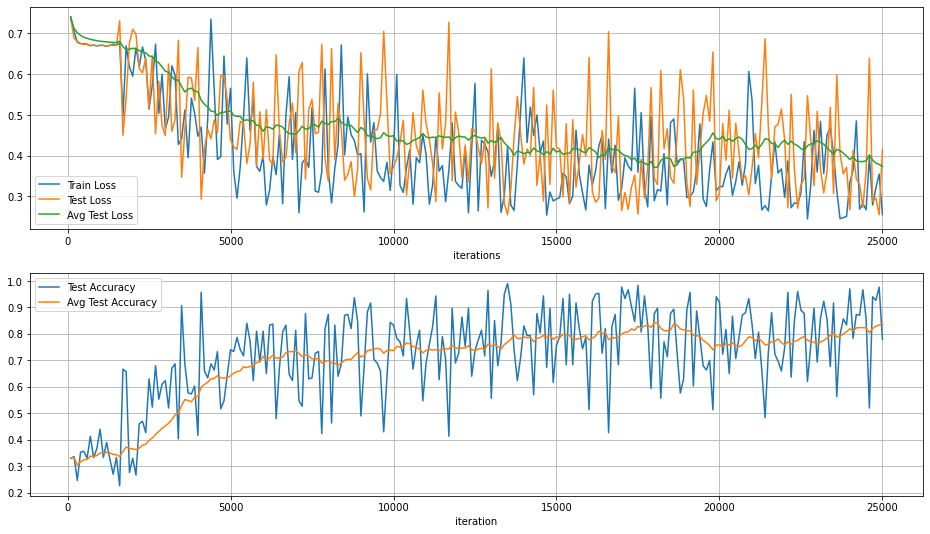

In [62]:
# K = 1, N = 3
num_samples_per_class=1
num_classes=3
meta_batch_size=128
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64_gru16_b128.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64_gru16_b128.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

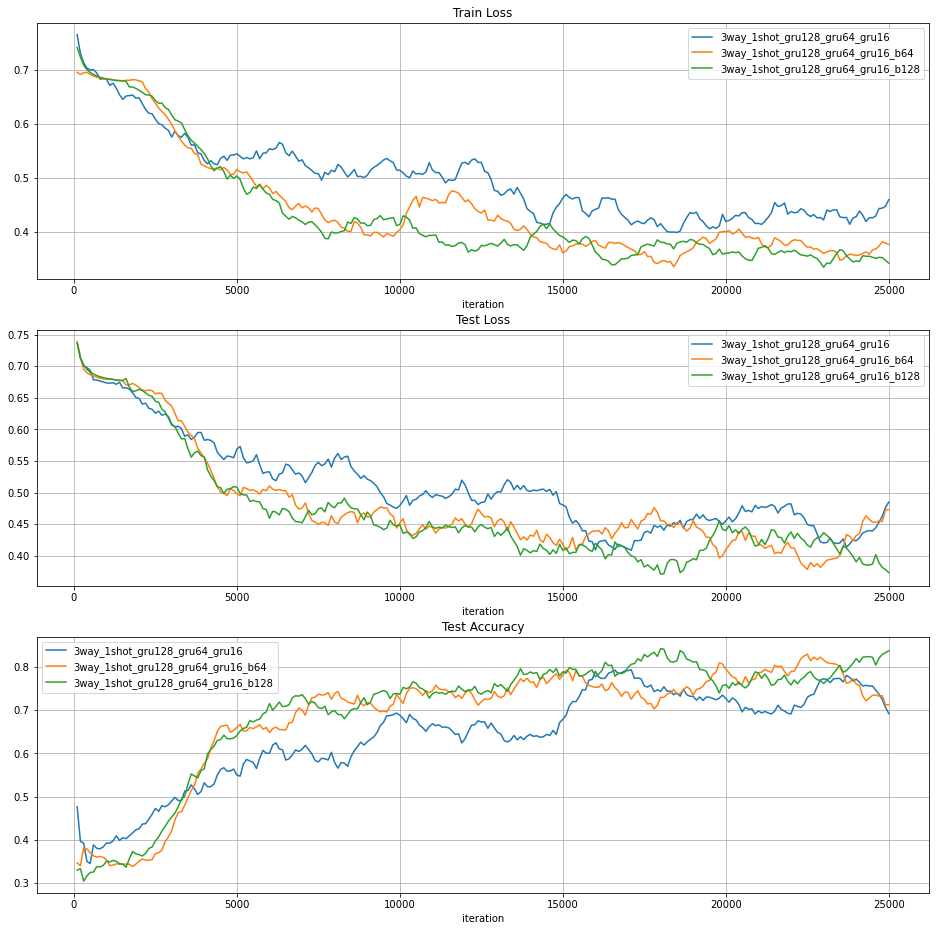

In [21]:
csv_log_files = ['logs/log_3way_1shot_gru128_gru64_gru16.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru16_b64.csv',
                 'logs/log_3way_1shot_gru128_gru64_gru16_b128.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_gru128_64_32_16_b128.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()

### Try GRU(128, 64, 16) with batch size of 128 on K=1,N=5

*****Iter 100*****
Train Loss: 1.2171091 Test Loss: 1.2184834
Test Accuracy 0.212
*****Iter 200*****
Train Loss: 1.0988227 Test Loss: 1.1059004
Test Accuracy 0.116
*****Iter 300*****
Train Loss: 1.0686651 Test Loss: 1.0695319
Test Accuracy 0.186
*****Iter 400*****
Train Loss: 1.0564451 Test Loss: 1.0582446
Test Accuracy 0.19
*****Iter 500*****
Train Loss: 1.0492513 Test Loss: 1.0499719
Test Accuracy 0.172
*****Iter 600*****
Train Loss: 1.0460583 Test Loss: 1.0450852
Test Accuracy 0.192
*****Iter 700*****
Train Loss: 1.0429693 Test Loss: 1.0441803
Test Accuracy 0.166
*****Iter 800*****
Train Loss: 1.0420401 Test Loss: 1.0442384
Test Accuracy 0.126
*****Iter 900*****
Train Loss: 1.038481 Test Loss: 1.0401481
Test Accuracy 0.216
*****Iter 1000*****
Train Loss: 1.0392805 Test Loss: 1.039801
Test Accuracy 0.204
*****Iter 1100*****
Train Loss: 1.0384103 Test Loss: 1.0402999
Test Accuracy 0.174
*****Iter 1200*****
Train Loss: 1.0403754 Test Loss: 1.0398126
Test Accuracy 0.226
*****Iter 1300**

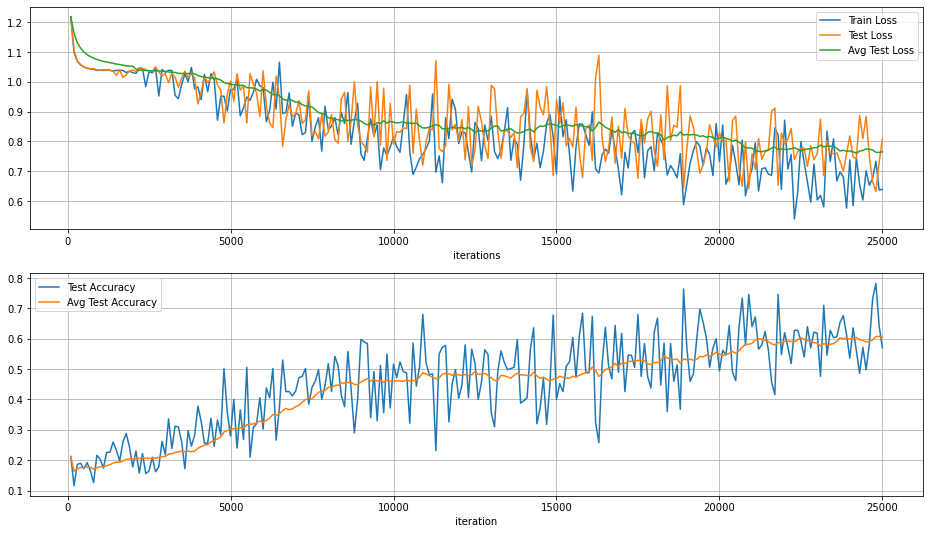

In [64]:
# K = 1, N = 5
num_samples_per_class=1
num_classes=5
meta_batch_size=128
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_gru128_gru64_gru16_b128.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_gru128_gru64_gru16_b128.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Try K=1,N=5, with the original LSTM based network with batch_size=16 to compare

*****Iter 100*****
Train Loss: 1.220499 Test Loss: 1.257664
Test Accuracy 0.2
*****Iter 200*****
Train Loss: 1.1669728 Test Loss: 1.1598665
Test Accuracy 0.2
*****Iter 300*****
Train Loss: 1.148841 Test Loss: 1.1465362
Test Accuracy 0.2
*****Iter 400*****
Train Loss: 1.1352593 Test Loss: 1.1351624
Test Accuracy 0.2
*****Iter 500*****
Train Loss: 1.1314886 Test Loss: 1.1320893
Test Accuracy 0.2
*****Iter 600*****
Train Loss: 1.1323938 Test Loss: 1.1324078
Test Accuracy 0.2
*****Iter 700*****
Train Loss: 1.1325841 Test Loss: 1.1302341
Test Accuracy 0.2
*****Iter 800*****
Train Loss: 1.1288259 Test Loss: 1.1309032
Test Accuracy 0.2
*****Iter 900*****
Train Loss: 1.1301215 Test Loss: 1.1306431
Test Accuracy 0.2
*****Iter 1000*****
Train Loss: 1.129421 Test Loss: 1.130546
Test Accuracy 0.2
*****Iter 1100*****
Train Loss: 1.1299261 Test Loss: 1.1299416
Test Accuracy 0.2
*****Iter 1200*****
Train Loss: 1.1286763 Test Loss: 1.1256832
Test Accuracy 0.2
*****Iter 1300*****
Train Loss: 1.1324115 

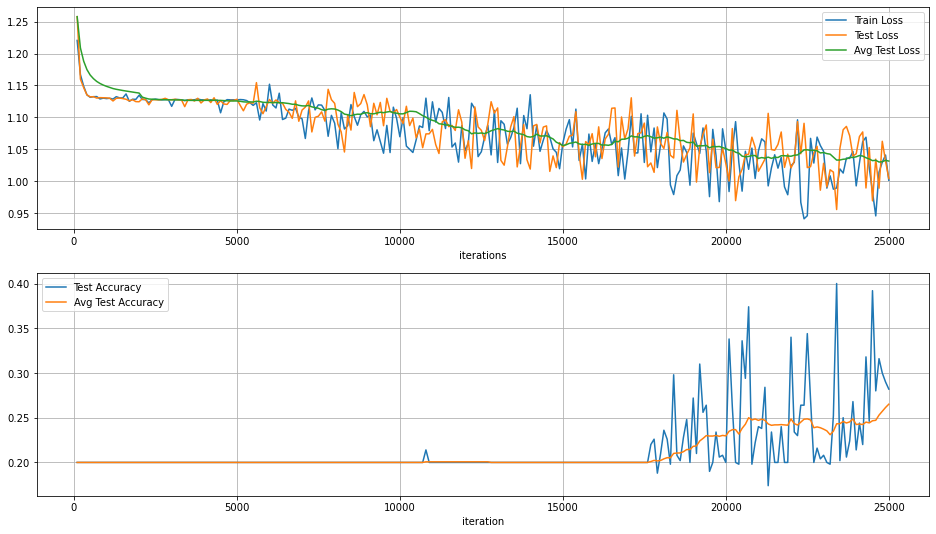

In [7]:
# K = 1, N = 5
num_samples_per_class=1
num_classes=5
meta_batch_size=16
logdir = 'logs'
plotdir = 'plots'

# filenames
csv_fname = os.path.join(logdir, 'log_{}way_{}shot_lstm_b16.csv'.format(num_classes, num_samples_per_class))
plot_fname = os.path.join(plotdir, 'plot_{}way_{}shot_lstm_b16.png'.format(num_classes, num_samples_per_class))

# create folders if it does not exist
if not os.path.exists(logdir):
    os.system('mkdir -p {}'.format(logdir))
if not os.path.exists(plotdir):
    os.system('mkdir -p {}'.format(plotdir))

with open(csv_fname, 'a+', newline='') as csvfile:
    fieldnames = ['iter',       \
                    'train_loss', \
                    'test_loss',  \
                    'acc'         ]
    # write header
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    steps, loss, acc = main(num_classes=num_classes, num_samples=num_samples_per_class, meta_batch_size=meta_batch_size, random_seed=1234)

    for i in range(len(steps)):
        csv_writer.writerow({   'iter'          : steps[i],   \
                                'train_loss'    : loss[i,0],  \
                                'test_loss'     : loss[i,1],  \
                                'acc'           : acc[i]        })

    moving_avg_test_loss = moving_average(loss[:,1], 20)
    moving_avg_test_acc = moving_average(acc, 20)
    print('Achieved test accuracy: {:.2f}%'.format(np.max(moving_avg_test_acc[-5:])*100.0))

    # display training results
    plt.figure(figsize=(16,9))
    plt.title('Loss and Accuracy [K={}, N={}]'.format(num_samples_per_class, num_classes))
    plt.subplot(2,1,1)
    plt.plot(steps, loss[:,0])
    plt.plot(steps, loss[:,1])
    plt.plot(steps, moving_avg_test_loss[:len(steps)])
    plt.grid()
    plt.legend(['Train Loss', 'Test Loss', 'Avg Test Loss'])
    plt.xlabel('iterations')

    plt.subplot(2,1,2)
    plt.plot(steps, acc)
    plt.plot(steps, moving_avg_test_acc[:len(steps)])
    plt.grid()
    plt.legend(['Test Accuracy', 'Avg Test Accuracy'])
    plt.xlabel('iteration')

    plt.savefig(plot_fname)
    plt.show()

### Compare

/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shubham/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

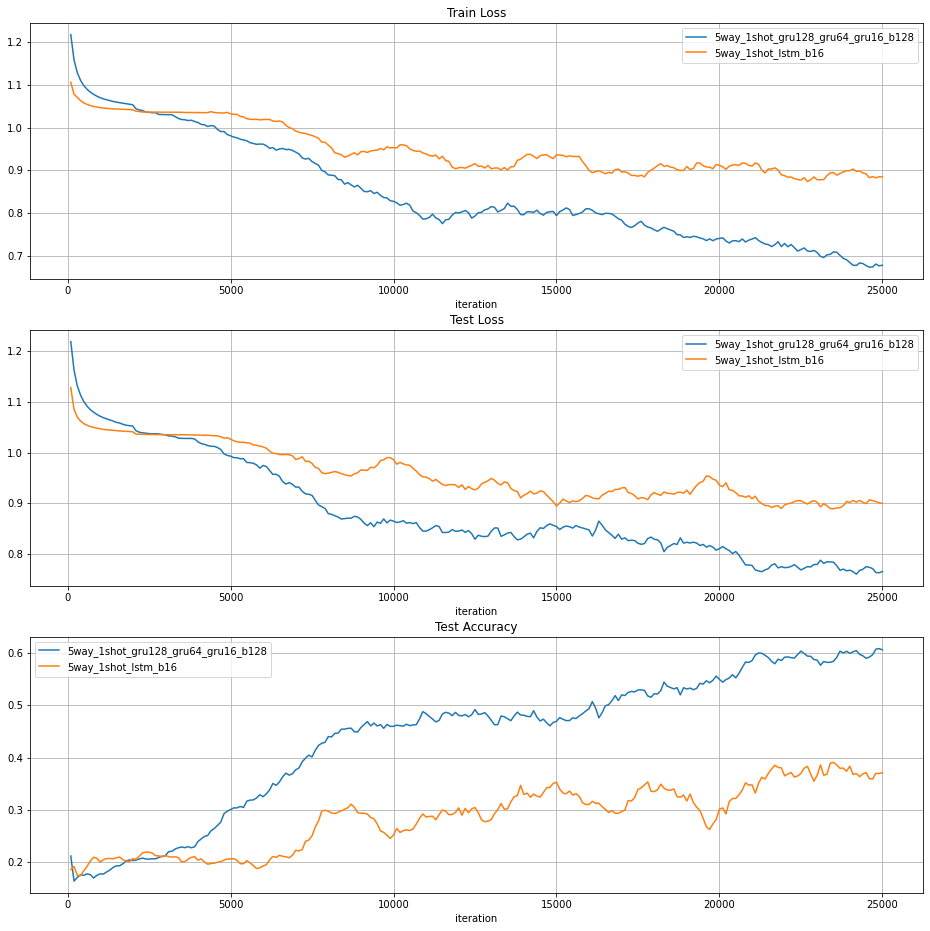

In [8]:
csv_log_files = ['logs/log_5way_1shot_gru128_gru64_gru16_b128.csv',
                 'logs/log_5way_1shot_lstm_b16.csv']

legend = [csv_log_files[i][9:-4]
            for i in range(len(csv_log_files))]

# plot filename
plot_fname = 'plots/compare_plots_5way_1shot_gru128_64_32_16_b128.png'

# plot graph
plt.figure(figsize=(16,16))

for i in range(len(csv_log_files)):
    iteration, train_loss, test_loss, test_acc  = [], [], [], []
    
    with open(csv_log_files[i]) as file:
        reader = csv.DictReader( file )
        for line in reader:
            iteration.append(int(line['iter']))
            train_loss.append(float(line['train_loss']))
            test_loss.append(float(line['test_loss']))
            test_acc.append(float(line['acc']))

    # get moving average for each term
    train_loss = moving_average(train_loss, 20)
    test_loss = moving_average(test_loss, 20)
    test_acc = moving_average(test_acc, 20)
    
    # plot graphs
    plt.subplot(3,1,1)
    plt.plot(iteration, train_loss)
    
    plt.subplot(3,1,2)
    plt.plot(iteration, test_loss)
    
    plt.subplot(3,1,3)
    plt.plot(iteration, test_acc)

# info
plt.subplot(3,1,1)
plt.legend(legend)
plt.grid()
plt.title('Train Loss')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.legend(legend)
plt.grid()
plt.title('Test Loss')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.legend(legend)
plt.grid()
plt.title('Test Accuracy')
plt.xlabel('iteration')

# save plot to file
plt.savefig(plot_fname)
plt.show()